In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow import keras

## Extract desired emotion file paths from RAVDESS

In [2]:
Ravdess = "data/RAVDESS/"
directory = 'data/preprocessed/' #save directory

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # SELECT INTENSITY HERE
        if (part[2] == '01') or (part[3] == '02'):
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,calm,data/RAVDESS/Actor_01/03-01-02-02-01-01-01.wav


In [4]:
Ravdess_df['Emotions'].value_counts()

neutral     96
calm        96
happy       96
sad         96
angry       96
fear        96
disgust     96
surprise    96
Name: Emotions, dtype: int64

In [5]:
data_path = pd.concat([Ravdess_df,  ], axis = 0)
data_path.to_csv(directory + "data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,calm,data/RAVDESS/Actor_01/03-01-02-02-01-01-01.wav


C:\Users\Evan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


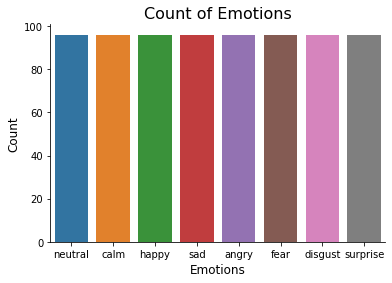

In [6]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Choose your emotions here

In [7]:
#data_path.loc[data_path['Emotions'] == 'calm','Emotions'] = 'neutral'

#data_path.loc[data_path['Emotions'] == 'happy','Emotions'] = 'neutral'

#data_path.loc[data_path['Emotions'] == 'angry','Emotions'] = 'stress'

#data_path.loc[data_path['Emotions'] == 'sad','Emotions'] = 'stress'

data_path.loc[data_path['Emotions'] == 'fear','Emotions'] = 'stress'

data_path = data_path[(data_path['Emotions'] == 'neutral') | (data_path['Emotions'] == 'stress')]

In [8]:
data_path['Emotions'].value_counts()

neutral    96
stress     96
Name: Emotions, dtype: int64

In [9]:
len(data_path)

192

## Extract raw time signals

In [10]:
sample_rate = 22050

raw = []
i = 0
for path in data_path.Path:
    sample, sr = librosa.load(path, sr = sample_rate)
    raw.append(sample)
    if(i%100 ==0):
        print(i)
    i+=1

0
100


In [11]:
len(raw)

192

In [12]:
raw_labels = np.array(data_path['Emotions'])

In [13]:
np.save(directory + 'raw.npy', raw)
np.save(directory + 'raw_labels.npy', raw_labels)

C:\Users\Evan\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


## Keep 5th - 90th percentile audio lengths to remove outliers

In [14]:
raw = np.load(directory + 'raw.npy', allow_pickle = True)
raw_labels = np.load(directory + 'raw_labels.npy', allow_pickle = True)

In [15]:
vec_length = np.vectorize(lambda x: len(x))

In [16]:
lengths = pd.DataFrame(np.stack((vec_length(raw), np.array(range(0,len(raw)))), axis = 1))

In [17]:
df = pd.DataFrame(lengths)

In [18]:
df.describe()

,0,1
count,192.000000,192.000000
mean,78781.640625,95.500000
std,6004.540550,55.569776
min,67688.000000,0.000000
25%,75045.000000,47.750000
50%,78724.000000,95.500000
75%,82403.000000,143.250000
max,110361.000000,191.000000


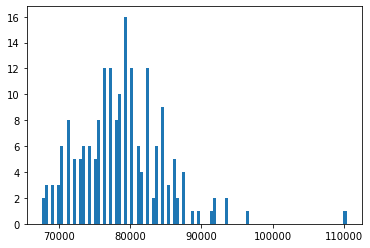

In [19]:
tuples = plt.hist(lengths[0], bins = 100)

In [20]:
lower = np.quantile(lengths[0], 0.05)
lower

69895.0

In [21]:
upper = np.quantile(lengths[0], 0.9)
upper

86007.5

In [22]:
lengths_clip = lengths[(lengths[0] > lower) & (lengths[0] < upper)]

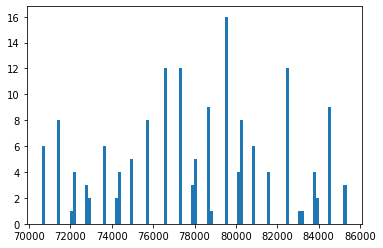

In [23]:
tuples = plt.hist(lengths_clip[0], bins = 100)

In [24]:
raw_clips = raw[lengths[(lengths[0] > lower) & (lengths[0] < upper)][1]]

In [25]:
padded_labels = raw_labels[lengths[(lengths[0] > lower) & (lengths[0] < upper)][1]]

In [26]:
lengths_clip.describe()

,0,1
count,161.000000,161.000000
mean,78052.428571,97.950311
std,3992.146767,55.054836
min,70631.000000,0.000000
25%,75045.000000,51.000000
50%,77989.000000,102.000000
75%,80931.000000,143.000000
max,85346.000000,191.000000


## Zero pad all clips to the same length

In [27]:
# change maxlen to a nice number just below upper
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_clips, maxlen = 85980, padding = 'pre', dtype = 'float32')

In [28]:
np.save(directory + 'padded.npy', padded_inputs)
np.save(directory + 'padded_labels.npy', padded_labels)

## Balance the number of neutral and stress samples 

In [29]:
padded_inputs = np.load(directory + 'padded.npy')
padded_labels = np.load(directory + 'padded_labels.npy', allow_pickle=True)

In [30]:
print(len(padded_inputs))

161


In [31]:
(padded_labels=='neutral').sum()

85

In [32]:
(padded_labels=='stress').sum()

76

In [33]:
indices = np.arange(len(padded_inputs))
neutral_indices = indices[padded_labels=='neutral']
stress_indices = indices[padded_labels=='stress']

if (padded_labels=='neutral').sum() > (padded_labels=='stress').sum():
    np.random.shuffle(neutral_indices)
    neutral_indices = neutral_indices[:(padded_labels=='stress').sum()]
    both = np.concatenate((neutral_indices,stress_indices))
    padded_inputs = padded_inputs[both]
    padded_labels = padded_labels[both]
elif (padded_labels=='neutral').sum() < (padded_labels=='stress').sum():
    np.random.shuffle(stress_indices)
    stress_indices = stress_indices[:(padded_labels=='neutral').sum()]
    both = np.concatenate((neutral_indices,stress_indices))
    padded_inputs = padded_inputs[both]
    padded_labels = padded_labels[both]

In [34]:
(padded_labels=='neutral').sum()

76

In [35]:
(padded_labels=='stress').sum()

76

## Data augmentation to extract MFCCs

In [36]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*3000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [37]:
n_fft = 512
hop_length = 128
n_mfcc = 12

def extract_features(data):
    # MFCC
    mfcc = librosa.feature.mfcc(y = data, n_fft = n_fft, hop_length = hop_length, n_mfcc = n_mfcc, )
    #mfcc_delta = librosa.feature.delta(mfcc)
    #mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    #mfcc = np.expand_dims(mfcc, axis = -1)
    #mfcc_delta = np.expand_dims(mfcc_delta, axis = -1)
    #mfcc_delta2 = np.expand_dims(mfcc_delta2, axis = -1)
    result = mfcc
    #result = np.concatenate ((mfcc, mfcc_delta, mfcc_delta2), axis = -1)
    #print(result.shape)
    return result

def get_features(data):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    #data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    #result = np.array(res1)
    # data with noise
    #print(res1.shape)
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    #result = np.stack((result, res2)) # stacking vertically
    #print(result.shape)
    # data with stretching and pitching
   # new_data = stretch(data)
    data_stretch_pitch = pitch(data, sample_rate, 0.7)
    res3 = extract_features(data_stretch_pitch)
    #result = np.stack((res1, res2, res3)) # stacking vertically
    
    data_stretch_pitch = pitch(data, sample_rate, -0.7)
    res4 = extract_features(data_stretch_pitch)
    
    data_shift = shift(data)
    res5 = extract_features(data_stretch_pitch)
    result = np.stack((res1, res2, res3, res4, res5)) # stacking vertically
    #print(result.shape)
    return result

In [38]:
X, Y = [], []
count = 0
for data, emotion in zip(padded_inputs, padded_labels):
    feature = get_features(data)
    for ele in feature:
        #print(ele.shape)
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
        #print('here')
    if(count%100 == 0):
        print(count)
    count += 1

0
100


In [39]:
print('done')

done


In [40]:
len(X)

760

In [41]:
mfccs = np.stack(X)


In [42]:
mfccs.shape

(760, 12, 672)

In [43]:
np.save(directory + 'mfccs.npy', mfccs)
#np.save(directory + 'mfccs_delta.npy', mfccs)

In [44]:
np.save(directory + 'str_labels.npy', np.array(Y))

In [45]:
np.array(Y).shape

(760,)